# Intro

## Standard modules

In [70]:
import os, sys
import pathlib
import requests

In [81]:
import numpy as np

In [2]:
import arxiv

In [67]:
from tqdm.auto import tqdm, trange

In [58]:
import pymupdf4llm

In [103]:
from sentence_transformers import util

In [106]:
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

## Personal modules

In [53]:
from toolbox.updater import time_is_now

In [54]:
from file2text import file2text

In [55]:
from first_rough_cleaning import first_text_cleaner

In [77]:
from file_handler import *

In [57]:
from jina4lote import jina4lote

## Folders

In [88]:
VECTOR_FOLDER='./NewProcessedData/vectors/'

In [63]:
BENCHMARK_FOLDER='./NewProcessedData/benchmarks/'

# Get Witten

To be honest, the main aim of the present section is to get some expertise on the arxiv module, that seems quite unessential (at least...), but funny.

## Functions

In [21]:
def get_file_name_from_arxiv_search(result):
    # get the surname of the first author
    surname=result.authors[0].name.split()[-1]
    title=result.title
    title=title.replace(' ', '_').replace('-', '_')
    return surname+'_'+title+'.pdf'

In [31]:
def print_info(result):
    print(result.title)
    print('------')
    print(result.summary)
    auths='\nby '+', '.join([auth.name for auth in result.authors])
    print(auths)

In [40]:
def save_pdf_from_arxiv_search(result, folder, print_abstract=True):
    '''
    It does what it says. 
    
    results: a single result of the arxiv search
    folder: where you want the final pdf to appear
    '''
    target_pdf=folder+get_file_name_from_arxiv_search(result)
    if print_abstract:
        print_info(result)
    response = requests.get(result.pdf_url, stream=True)
    if response.status_code == 200:
        with open(target_pdf, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                file.write(chunk)
        print(f"\nSaved: {target_pdf}")
    else:
        print(f"\nFailed to download: {result.title}")

## Run

In [34]:
client = arxiv.Client()

In [35]:
search = arxiv.Search(query = "au:witten AND ti:information")

In [36]:
first_result = next(client.results(search))

In [51]:
save_pdf_from_arxiv_search(first_result, BENCHMARK_FOLDER)

A Mini-Introduction To Information Theory
------
This article consists of a very short introduction to classical and quantum
information theory. Basic properties of the classical Shannon entropy and the
quantum von Neumann entropy are described, along with related concepts such as
classical and quantum relative entropy, conditional entropy, and mutual
information. A few more detailed topics are considered in the quantum case.

by Edward Witten

Saved: ./NewProcessedData/benchmarks/Witten_A_Mini_Introduction_To_Information_Theory.pdf


In [52]:
first_result.comment

'39 pp, various small improvements in this version'

Ok, so the number of pages in around what we usually have...

# Embed me!

We have 2 benchmarks: the Witten's paper and the merge of the UN documents about SDGs. They are opposite benchmarks: we expect the similarity of Witten's paper with all our reports to be minimal since the argument are quite distant, while the UN document should tell us how much the reports are aligned with the SDGs (not carved in the stone, but it should provide an idea). Let's convert them, using standard stuff from text analysis. 

## Files

In [83]:
pdfs=[file for file in os.listdir(BENCHMARK_FOLDER) if file.endswith('.pdf')]
pdfs.sort()

In [84]:
pdfs

['Goal-10-Fast-Facts.pdf',
 'Goal-11_Fast-Facts.pdf',
 'Goal-12_Fast-Facts.pdf',
 'Goal-13_Fast-Facts.pdf',
 'Goal-14_Fast-Facts.pdf',
 'Goal-15-Fast-Facts.pdf',
 'Goal-16-Fast-Facts.pdf',
 'Goal-17-Fast-Facts.pdf',
 'Goal-1_Fast-Facts.pdf',
 'Goal-2_Fast-Facts.pdf',
 'Goal-3_Fast-Facts.pdf',
 'Goal-4_Fast-Facts.pdf',
 'Goal-5_Fast-Facts.pdf',
 'Goal-6_Fast-Facts.pdf',
 'Goal-7_Fast-Facts.pdf',
 'Goal-8_Fast-Facts.pdf',
 'Goal-9-Fast-Facts.pdf',
 'Goal-Fast-Facts.pdf',
 'Witten_A_Mini_Introduction_To_Information_Theory.pdf']

## From pdf to md

In [85]:
for pdf in tqdm(pdfs):
    file_name_md=pdf.replace('.pdf', '.md')
    if not os.path.isfile(BENCHMARK_FOLDER+file_name_md):
        md_text = pymupdf4llm.to_markdown(BENCHMARK_FOLDER+pdf)
        pathlib.Path(BENCHMARK_FOLDER+file_name_md).write_bytes(md_text.encode())

  0%|          | 0/19 [00:00<?, ?it/s]

Processing ./NewProcessedData/benchmarks/Goal-10-Fast-Facts.pdf...
[                                        ] (0/2===================[====================                    ] (1/2===================[========================================] (2/2]
Processing ./NewProcessedData/benchmarks/Goal-11_Fast-Facts.pdf...
[                                        ] (0/2===================[====================                    ] (1/2===================[========================================] (2/2]
Processing ./NewProcessedData/benchmarks/Goal-12_Fast-Facts.pdf...
[                                        ] (0/2===================[====================                    ] (1/2===================[========================================] (2/2]
Processing ./NewProcessedData/benchmarks/Goal-13_Fast-Facts.pdf...
[                                        ] (0/2===================[====================                    ] (1/2===================[========================================] (2/2]
Processi

## From md to vec

In [86]:
for i_pdf, pdf in enumerate(tqdm(pdfs)):
    # vector file name
    vecfile=pdf.replace('.pdf', '.txt')
    if not os.path.isfile(BENCHMARK_FOLDER+vecfile):
        # get the md file name
        file_name_md=pdf.replace('.pdf', '.md')
        # read the md file
        with open(BENCHMARK_FOLDER+file_name_md, 'r') as f:
            markdown_string = f.read()
        # embed the text
        md_vec=jina4lote(first_text_cleaner(markdown_string))
    
        # save the md vec
        np.savetxt(BENCHMARK_FOLDER+vecfile, md_vec)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

# Everybody Needs Witten
Actually, probably not.

## Witten's vector

In [94]:
wittenvecfile=[file for file in os.listdir(BENCHMARK_FOLDER) if file.startswith('Witten') and file.endswith('.txt')][0]

In [99]:
wittenvec=np.genfromtxt(BENCHMARK_FOLDER+wittenvecfile)

## Reports' vectors

In [90]:
vecfiles=os.listdir(VECTOR_FOLDER)

In [91]:
vecfiles.sort()

In [104]:
cos_sims=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    vec=np.genfromtxt(VECTOR_FOLDER+vecfile)
    cos_sim=float(util.cos_sim(wittenvec, vec))
    print(f'{vecfile:})\tcos={cos_sim:.3f}')
    cos_sims[i]=cos_sim

  0%|          | 0/575 [00:00<?, ?it/s]

2015_01_ANGLO_AMERICAN_PLC.txt)	cos=0.801
2015_01_ANTOFAGASTA_PLC.txt)	cos=0.763
2015_01_CRODA_INTERNATIONAL_PLC.txt)	cos=0.800
2015_01_JOHNSON_MATTHEY_PLC.txt)	cos=0.766
2015_01_RIO_TINTO_PLC.txt)	cos=0.800
2015_01_SYNTHOMER_PLC.txt)	cos=0.798
2015_02_BARRATT_DEVELOPMENTS_PLC.txt)	cos=0.794
2015_02_BERKELEY_GROUP_HOLDINGS_(THE)_PLC.txt)	cos=0.769
2015_02_BURBERRY_GROUP_PLC.txt)	cos=0.738
2015_02_INFORMA_PLC.txt)	cos=0.771
2015_02_INTERCONTINENTAL_HOTELS_GROUP_PLC.txt)	cos=0.759
2015_02_NEXT_PLC.txt)	cos=0.786
2015_02_PERSIMMON_PLC.txt)	cos=0.768
2015_02_RELX_PLC.txt)	cos=0.810
2015_02_WHITBREAD_PLC.txt)	cos=0.763
2015_03_Associated_British_Foods_PLC.txt)	cos=0.795
2015_03_British_American_Tobacco_PLC.txt)	cos=0.753
2015_03_Diageo_PLC.txt)	cos=0.797
2015_03_Imperial_Brands_PLC.txt)	cos=0.768
2015_03_Marks_and_Spencer_Group_PLC.txt)	cos=0.779
2015_03_Reckitt_Benckiser_Group_PLC.txt)	cos=0.780
2015_03_Sainsbury_(J)_PLC.txt)	cos=0.764
2015_03_Unilever_PLC.txt)	cos=0.749
2015_04_BP_PLC.txt

2019_05_STANDARD_CHARTERED_PLC.txt)	cos=0.788
2019_06_AstraZeneca_PLC.txt)	cos=0.783
2019_06_Convatec_Group_PLC.txt)	cos=0.783
2019_06_GSK_PLC.txt)	cos=0.810
2019_06_Genus_PLC.txt)	cos=0.769
2019_06_Smith_&_Nephew_PLC.txt)	cos=0.790
2019_07_HALMA_PLC.txt)	cos=0.790
2019_07_IMI_PLC.txt)	cos=0.793
2019_07_INTERTEK_GROUP_PLC.txt)	cos=0.779
2019_07_MELROSE_INDUSTRIES_PLC.txt)	cos=0.773
2019_07_RENTOKIL_INITIAL_PLC.txt)	cos=0.795
2019_07_SMITH_(DS)_PLC.txt)	cos=0.763
2019_08_BIG_YELLOW_GROUP_PLC.txt)	cos=0.786
2019_08_DERWENT_LONDON_PLC.txt)	cos=0.785
2019_08_LAND_SECURITIES_GROUP_PLC.txt)	cos=0.782
2019_08_RIGHTMOVE_PLC.txt)	cos=0.763
2019_08_SHAFTESBURY_CAPITAL_PLC.txt)	cos=0.743
2019_08_TRITAX_BIG_BOX_REIT_PLC.txt)	cos=0.724
2019_09_AUTO_TRADER_GROUP_PLC.txt)	cos=0.784
2019_10_BT_GROUP_PLC.txt)	cos=0.779
2019_10_FILTRONIC_PLC.txt)	cos=0.773
2019_10_SPIRENT_COMMUNICATIONS_PLC.txt)	cos=0.784
2019_10_VODAFONE_GROUP_PLC.txt)	cos=0.782
2019_11_CENTRICA_PLC.txt)	cos=0.763
2019_11_GOOD_ENERGY_G

2022_08_RIGHTMOVE_PLC.txt)	cos=0.753
2022_08_SEGRO_PLC.txt)	cos=0.758
2022_08_SHAFTESBURY_CAPITAL_PLC.txt)	cos=0.787
2022_08_TRITAX_BIG_BOX_REIT_PLC.txt)	cos=0.775
2022_08_UNITE_GROUP_PLC.txt)	cos=0.788
2022_09_BIG_TECHNOLOGIES_PLC.txt)	cos=0.773
2022_09_BYTES_TECHNOLOGY_GROUP_PLC.txt)	cos=0.778
2022_09_COMPUTACENTER_PLC.txt)	cos=0.782
2022_09_DELIVEROO_PLC.txt)	cos=0.757
2022_09_SAGE_GROUP_PLC.txt)	cos=0.783
2022_09_TRUSTPILOT_GROUP_PLC.txt)	cos=0.781
2022_10_AIRTEL_AFRICA_PLC.txt)	cos=0.778
2022_10_BT_GROUP_PLC.txt)	cos=0.814
2022_10_FILTRONIC_PLC.txt)	cos=0.759
2022_10_GAMMA_COMMUNICATIONS_PLC.txt)	cos=0.772
2022_10_HELIOS_TOWERS_PLC.txt)	cos=0.754
2022_10_SPIRENT_COMMUNICATIONS_PLC.txt)	cos=0.786
2022_10_TELECOM_PLUS_PLC.txt)	cos=0.784
2022_10_VODAFONE_GROUP_PLC.txt)	cos=0.774
2022_11_CENTRICA_PLC.txt)	cos=0.771
2022_11_GOOD_ENERGY_GROUP_PLC.txt)	cos=0.772
2022_11_NATIONAL_GRID_PLC.txt)	cos=0.790
2022_11_PENNON_GROUP_PLC.txt)	cos=0.799
2022_11_RENEWI_PLC.txt)	cos=0.771
2022_11_SEVE

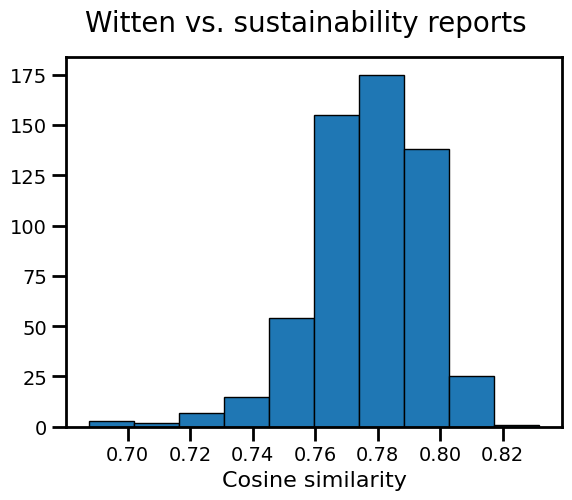

In [111]:
plt.hist(cos_sims, edgecolor='black')
plt.suptitle('Witten vs. sustainability reports', fontsize=20)
plt.xlabel('Cosine similarity', fontsize=16)
plt.show()